In [6]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# 1. Downloading the Data 

In [7]:
#DataLoading

def load_customer_data():
    tarball_path = Path("/Users/lauracechnicka/Desktop/WA_Fn-UseC_-Telco-Customer-Churn.csv")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        with tarfile.open(tarball_path) as customer_tarball:
            customer_tarball.extractall(path="datasets")
    return pd.read_csv(Path("/Users/lauracechnicka/Desktop/WA_Fn-UseC_-Telco-Customer-Churn.csv"))

customer = load_customer_data()

In [8]:
customer.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [9]:
# # Convert 'TotalCharges' to numeric, handling errors as 'coerce' 
customer['TotalCharges'] = customer['TotalCharges'].apply(pd.to_numeric, errors='coerce')
#And remove the customer ID
customer = customer.drop(columns=['customerID'])

In [10]:
customer.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [ ]:
customer.info()

In [ ]:
print(customer.columns)

# 2. Data pre-processing

In [11]:
#Split data into features (X) and target variable (y)
X = customer.drop(columns=['Churn'])
y = customer['Churn']

In [12]:
# Define preprocessing steps for numerical and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())                 
])

# Imputing missing values with most frequent value and one-hot encode categorical features
categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder())                           
])

# Combining preprocessing steps for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 3. Data Visualisation 

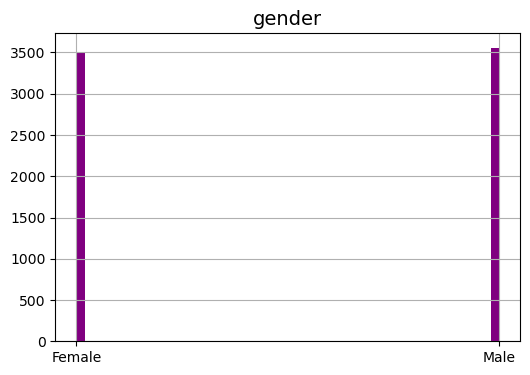

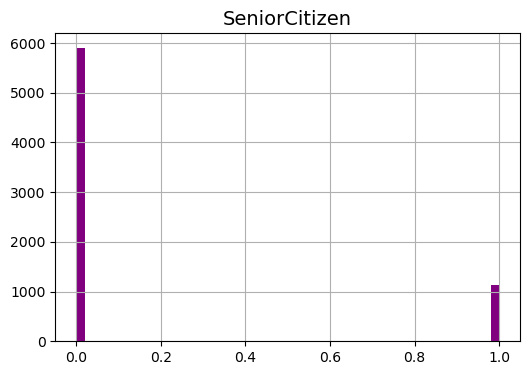

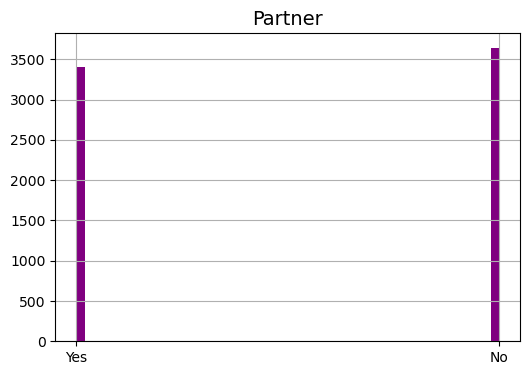

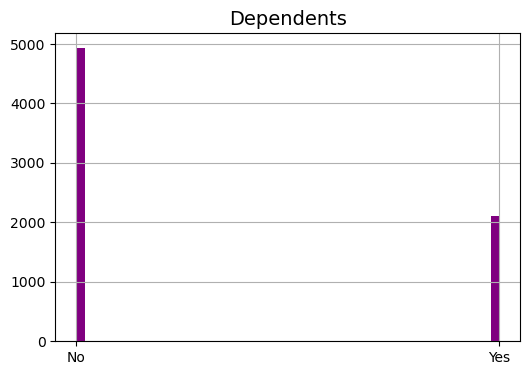

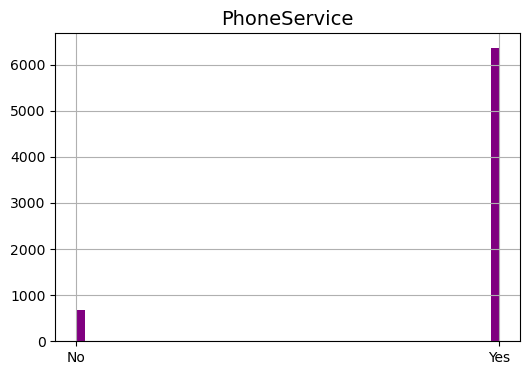

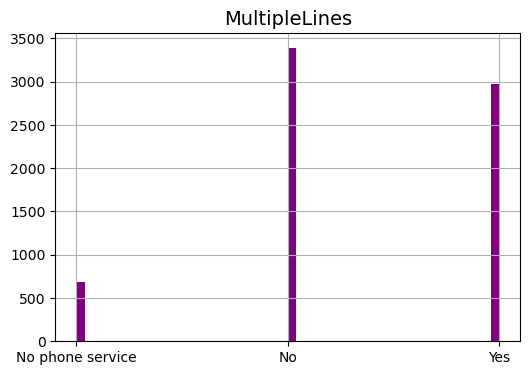

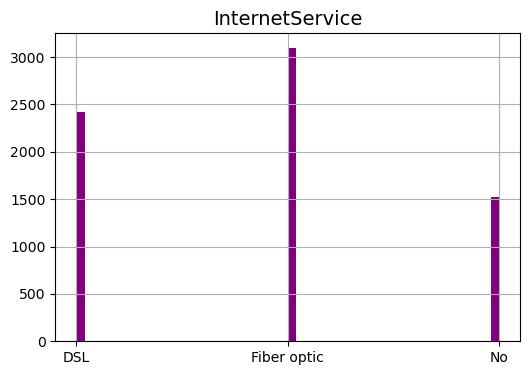

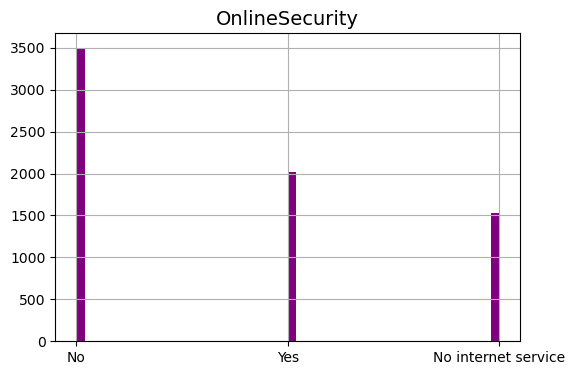

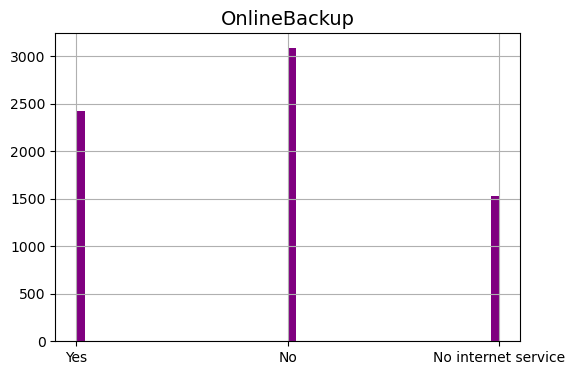

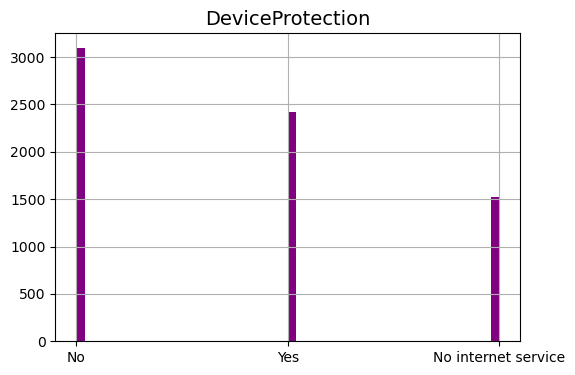

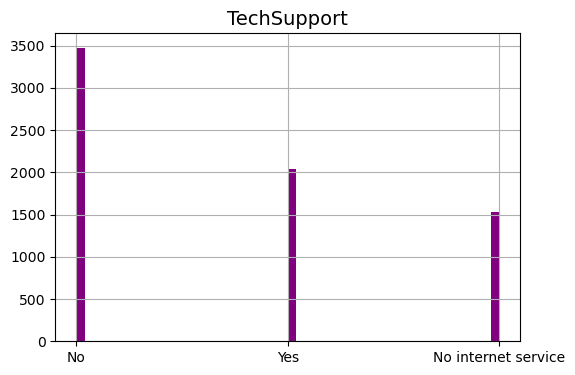

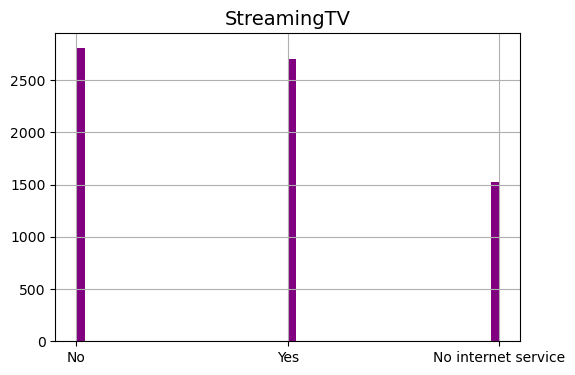

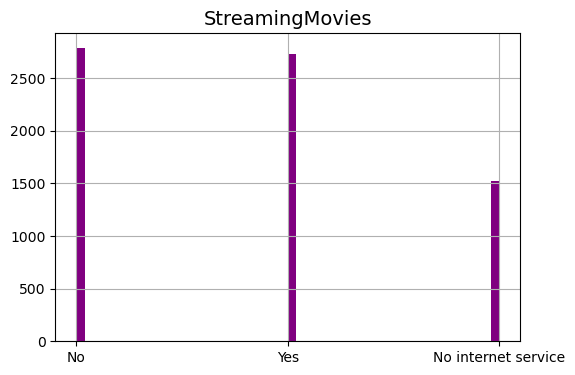

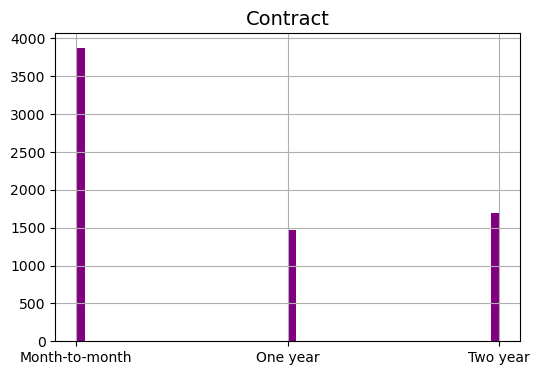

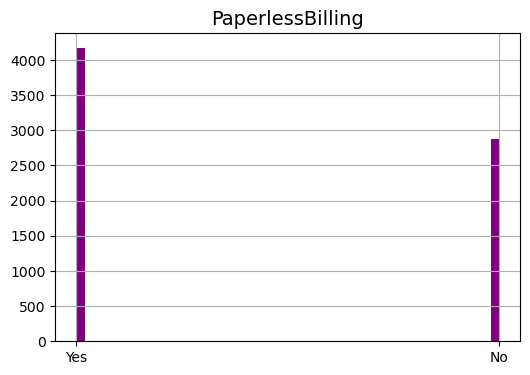

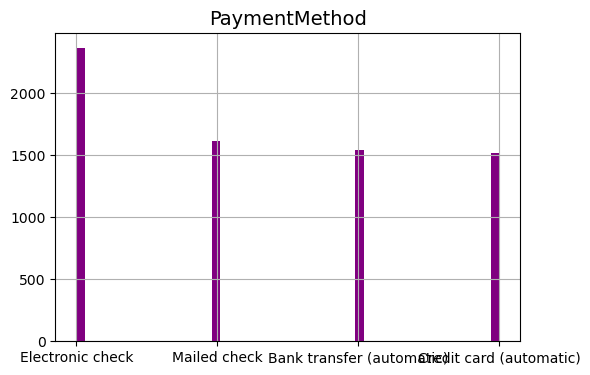

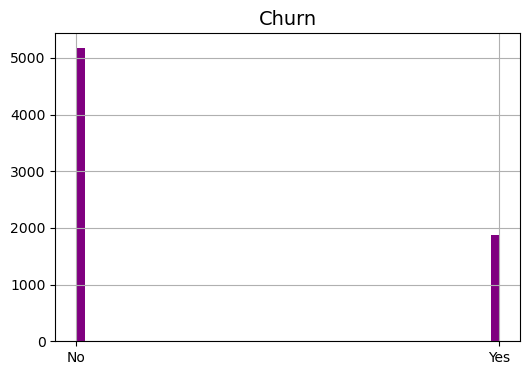

In [26]:
#Visualization of Non numeric Data
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

columns_to_plot = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
                   'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                   'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
                   'PaymentMethod', 'Churn']

for column in columns_to_plot:
    customer[column].hist(bins=50, figsize=(6, 4), color='purple')
    plt.title(column)
    plt.show()

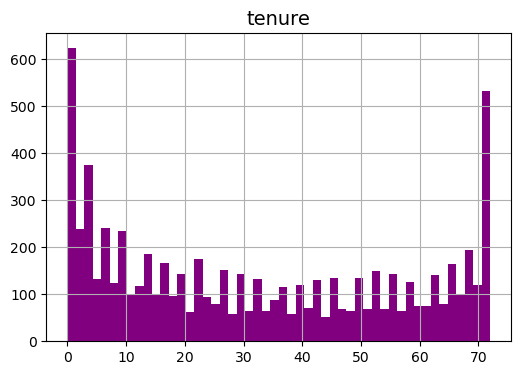

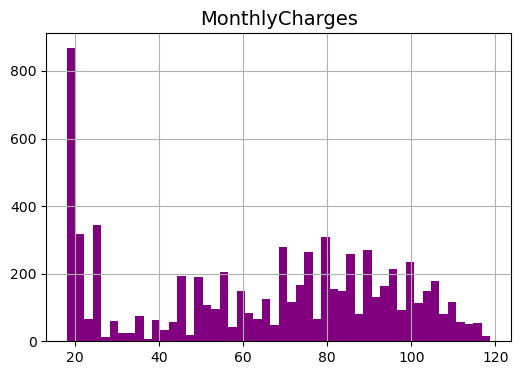

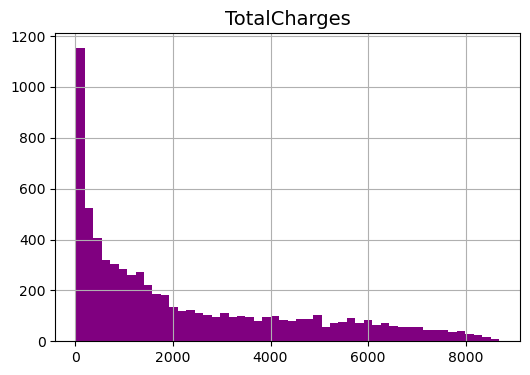

In [27]:
#Numerical Data

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

columns_to_plot = ['tenure','MonthlyCharges', 'TotalCharges']

for column in columns_to_plot:
    customer[column].hist(bins=50, figsize=(6, 4), color='purple')
    plt.title(column)
    plt.show()

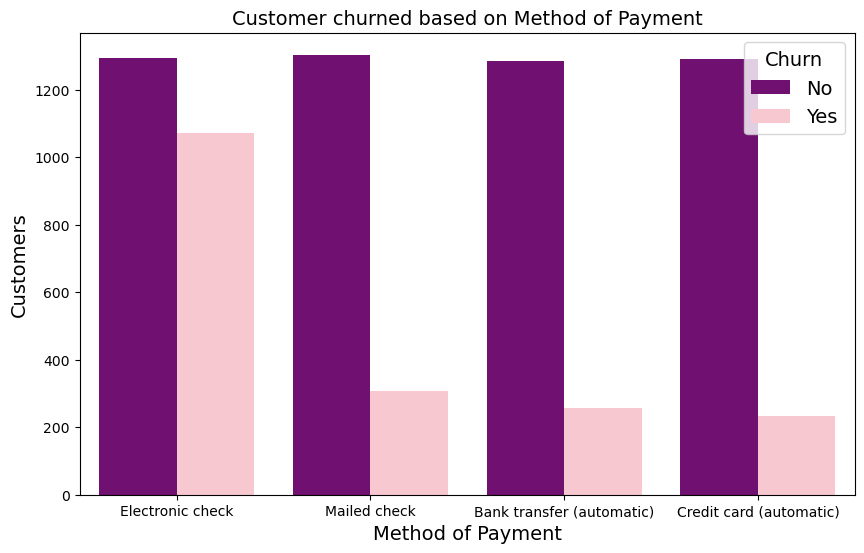

In [29]:
import seaborn as sns
plt.figure(figsize=(10,6))
custom_palette = ["purple", "pink"]
sns.countplot(data=customer,x='PaymentMethod',hue='Churn', palette=custom_palette)
plt.xlabel('Method of Payment')
plt.ylabel('Customers')
plt.title('Customer churned based on Method of Payment')
plt.show()

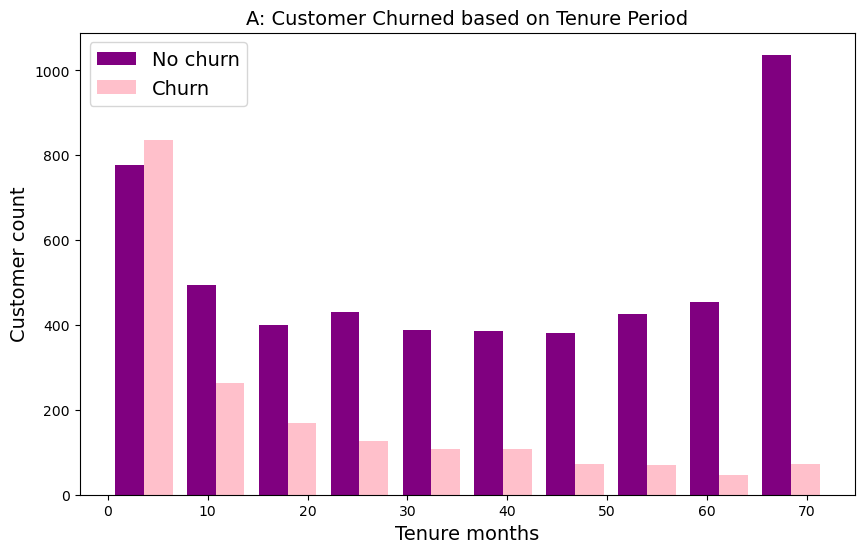

In [30]:
#Tenure
tenure_churn_no = customer[customer['Churn'] == 'No']['tenure']
tenure_churn_yes = customer[customer['Churn'] == 'Yes']['tenure']

plt.figure(figsize=(10,6))
plt.hist([tenure_churn_no,tenure_churn_yes],color=['purple','pink'],label=['No churn','Churn'])
plt.xlabel('Tenure months')
plt.ylabel('Customer count')
plt.title('A: Customer Churned based on Tenure Period')
plt.legend()
plt.show()

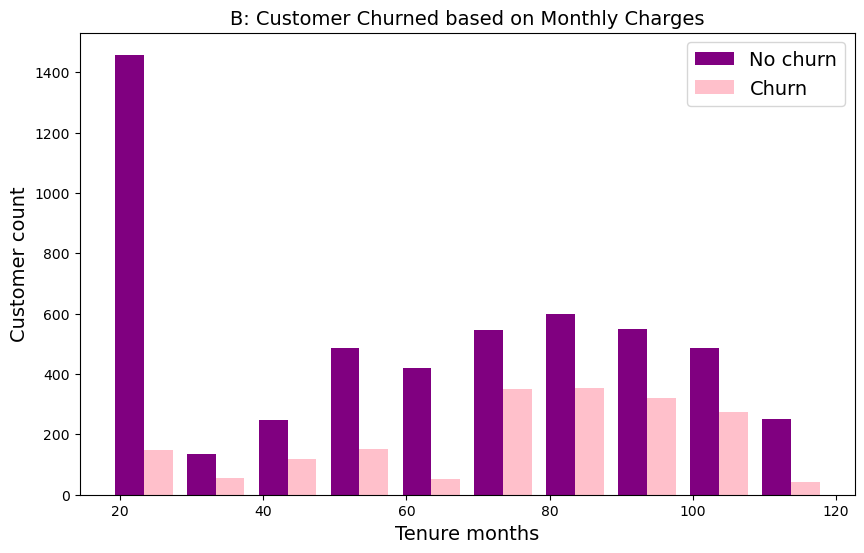

In [31]:
#Monthly Charges
tenure_churn_no = customer[customer['Churn'] == 'No']['MonthlyCharges']
tenure_churn_yes = customer[customer['Churn'] == 'Yes']['MonthlyCharges']

plt.figure(figsize=(10,6))
plt.hist([tenure_churn_no,tenure_churn_yes],color=['purple','pink'],label=['No churn','Churn'])
plt.xlabel('Tenure months')
plt.ylabel('Customer count')
plt.title('B: Customer Churned based on Monthly Charges')
plt.legend()
plt.show()

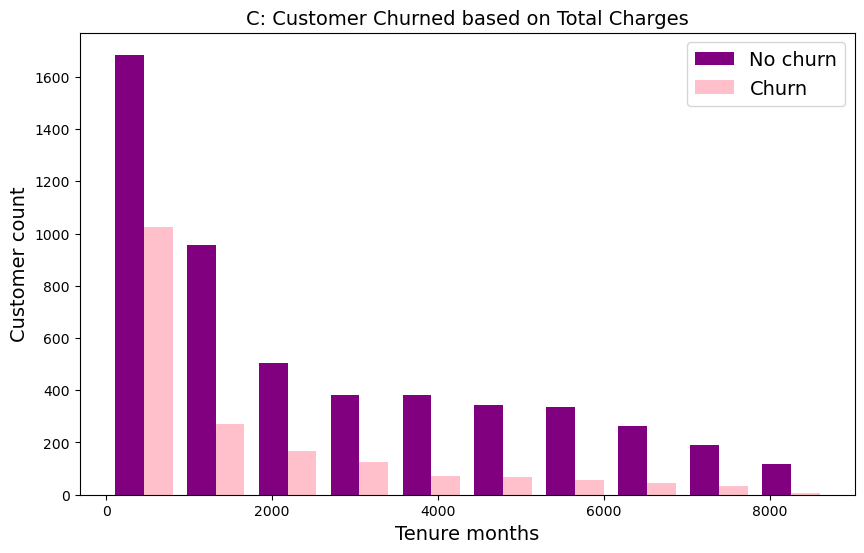

In [32]:
#Total Charges
tenure_churn_no = customer[customer['Churn'] == 'No']['TotalCharges']
tenure_churn_yes = customer[customer['Churn'] == 'Yes']['TotalCharges']

plt.figure(figsize=(10,6))
plt.hist([tenure_churn_no,tenure_churn_yes],color=['purple','pink'],label=['No churn','Churn'])
plt.xlabel('Tenure months')
plt.ylabel('Customer count')
plt.title('C: Customer Churned based on Total Charges')
plt.legend()
plt.show()

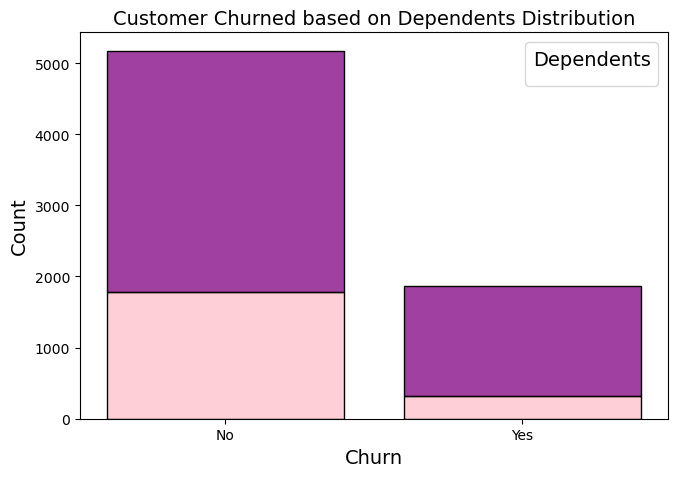

In [33]:
color_map = {"Yes": "pink", "No": "purple"}
plt.figure(figsize=(7, 5))
sns.histplot(data=customer, x="Churn", hue="Dependents", palette=color_map, multiple="stack", shrink=0.8)
plt.title("Customer Churned based on Dependents Distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.legend([], [], title="Dependents")

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


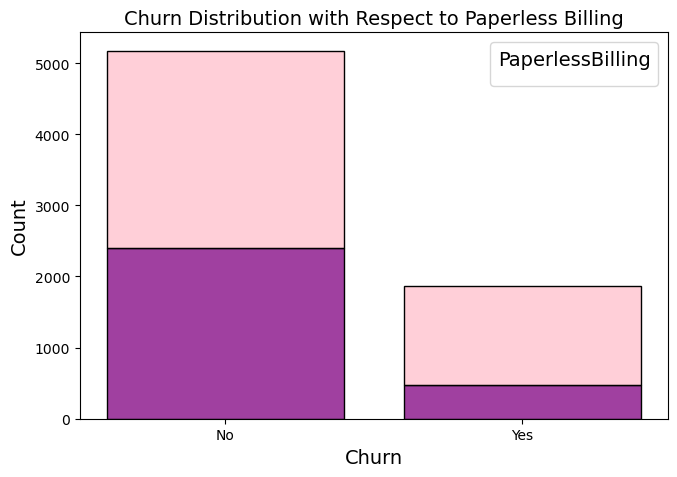

In [35]:
color_map = {"Yes": "pink", "No": "purple"}
plt.figure(figsize=(7, 5))
sns.histplot(data=customer, x="Churn", hue="PaperlessBilling", palette=color_map, multiple="stack", shrink=0.8)
plt.title("Churn Distribution with Respect to Paperless Billing")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.legend(title="PaperlessBilling")
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


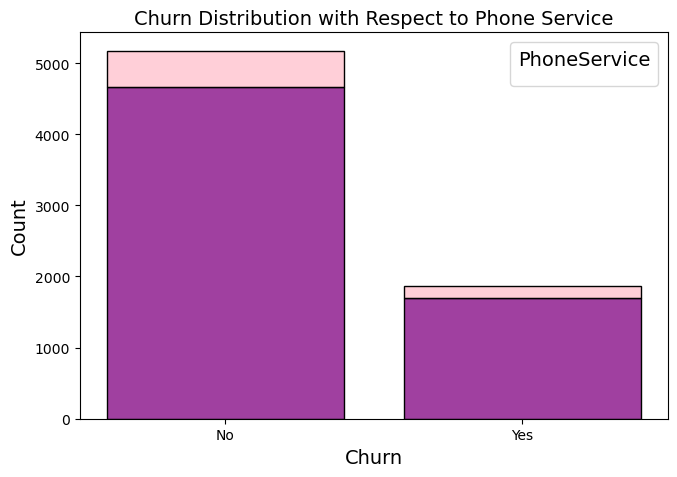

In [37]:
color_map = {"Yes": "purple", "No": "pink"}

plt.figure(figsize=(7, 5))
sns.histplot(data=customer, x="Churn", hue="PhoneService", palette=color_map, multiple="stack", shrink=0.8)
plt.title("Churn Distribution with Respect to Phone Service")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.legend(title="PhoneService")
plt.tight_layout()
plt.show()

In [38]:
import plotly.express as px
fig = px.box(customer, x='Churn', y='tenure', color='Churn', color_discrete_sequence=['purple'])

fig.update_yaxes(title_text='Tenure (Months)', row=1, col=1)

fig.update_xaxes(title_text='Churn', row=1, col=1)
fig.update_layout(autosize=True, width=750, height=600,
                  title='<b>Tenure vs Churn</b>',
                  title_font=dict(size=25, family='Courier'),
                  plot_bgcolor='white')

fig.show()

/var/folders/84/19q4403502b6ycn514dyj48c0000gn/T/ipykernel_33860/2235478843.py:1: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/var/folders/84/19q4403502b6ycn514dyj48c0000gn/T/ipykernel_33860/2235478843.py:2: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




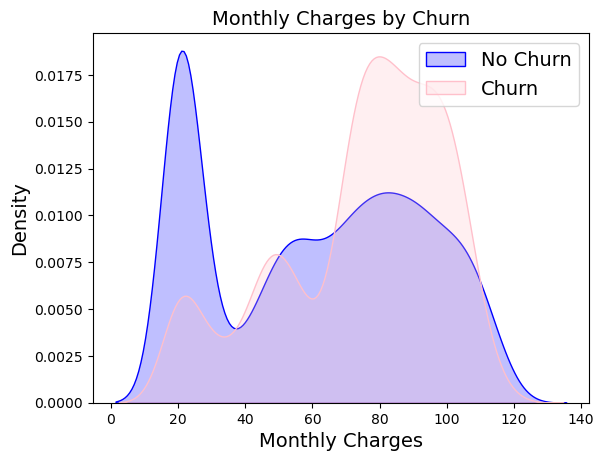

In [39]:
monthly_charges = sns.kdeplot(customer.MonthlyCharges[(customer['Churn'] == 'No')],color="blue",shade=True)
monthly_charges = sns.kdeplot(customer.MonthlyCharges[(customer['Churn']=='Yes')],ax=monthly_charges,color="pink",shade=True)
monthly_charges.legend(["No Churn","Churn"],loc="upper right")
monthly_charges.set_ylabel('Density')
monthly_charges.set_xlabel('Monthly Charges')
monthly_charges.set_title('Monthly Charges by Churn')
plt.show()

In [40]:
corr = customer.apply(lambda x: pd.factorize(x)[0]).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
corr_masked = corr.mask(mask)

fig = px.imshow(corr_masked,
                labels=dict(x="Variable", y="Variable", color="Correlation"),
                x=corr.columns,
                y=corr.columns,
                color_continuous_scale='turbo',  
                title="Correlation Heatmap")

fig.update_layout(width=800, height=600)
fig.show()

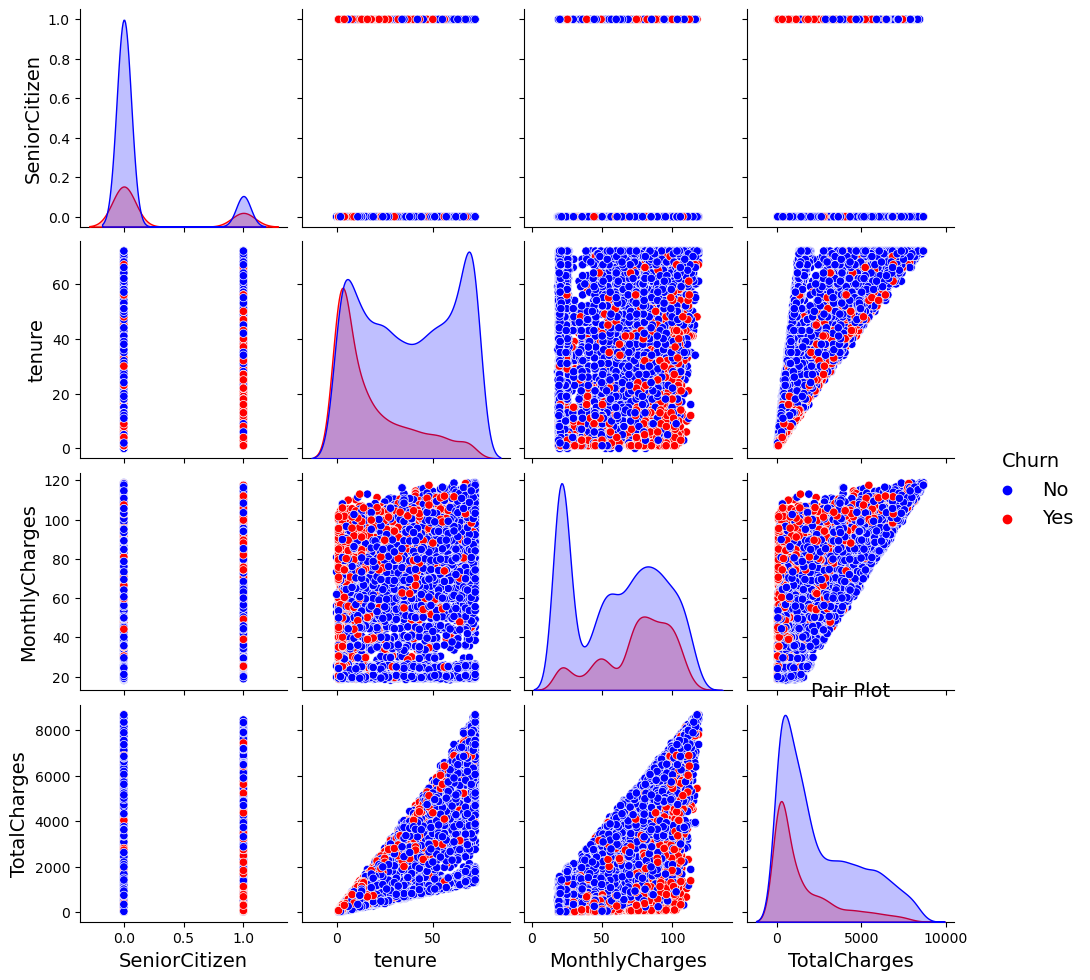

In [42]:
#Further exploring correlations 
custom_palette = ["blue", "red"]

sns.pairplot(data=customer, hue='Churn', palette=custom_palette)
plt.title('Pair Plot')
plt.show()

# 4. Using different models 

# 4.1 RandomForest classifier

In [48]:
# Create preprocessing pipeline and classifier
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

In [49]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
# Fit classifier on training data
clf.fit(X_train, y_train)

# Evaluate classifier on test data
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.7913413768630234


In [51]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.7913413768630234
Classification Report:
               precision    recall  f1-score   support

          No       0.82      0.91      0.87      1036
         Yes       0.65      0.46      0.54       373

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409



### 4.1.1. Improve upon this using grid search

In [52]:
# Define the hyperparameter grid to search
param_grid = {
    'classifier__n_estimators': [5, 10, 20],             
    'classifier__max_depth': [None, 5, 10],                
    'classifier__min_samples_split': [2, 5, 10],            
    'classifier__bootstrap': [True, False]                  
}

In [53]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy') 
grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEnco...
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__bootstrap': [True, False],
                         'classifier__max_depth': [None, 5, 10],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [5, 10, 20]},
             scoring='accuracy')

In [54]:
# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'classifier__bootstrap': False, 'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 20}
Best Score: 0.7989500330666495


### 4.1.3 Oversampling to tackle class imbalance

In [ ]:
# Address class imbalance using RandomOverSampler, use best model from grid search
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

In [ ]:
# Fit classifier on training data

rf_classifier = RandomForestClassifier(
    bootstrap=True,
    max_depth=5,
    min_samples_split=10,
    n_estimators=10
)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', rf_classifier)])

clf.fit(X_train_resampled, y_train_resampled)

In [ ]:
# Evaluate classifier on test data
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

## 4.2 K-nearest neighbours

In [16]:
# Create preprocessing pipeline and KNN classifier
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', KNeighborsClassifier())])

Accuracy: 0.7743080198722498
Classification Report:
               precision    recall  f1-score   support

          No       0.84      0.85      0.85      1036
         Yes       0.58      0.55      0.56       373

    accuracy                           0.77      1409
   macro avg       0.71      0.70      0.71      1409
weighted avg       0.77      0.77      0.77      1409



In [ ]:
# Fit classifier on training data
clf.fit(X_train, y_train)

In [ ]:
# Evaluate classifier on test data
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

### 4.2.1 Improve upon this using grid search

In [17]:
# Define the hyperparameter grid to search
param_grid = {
    'classifier__n_neighbors': [3, 5, 7],            
    'classifier__weights': ['uniform', 'distance'],  
    'classifier__metric': ['euclidean', 'manhattan'] 
}

/Users/lauracechnicka/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lauracechnicka/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/lauracechnicka/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/lauracechnicka/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/Users/laurac

/Users/lauracechnicka/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lauracechnicka/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/lauracechnicka/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/lauracechnicka/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/Users/laurac

/Users/lauracechnicka/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lauracechnicka/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/lauracechnicka/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/lauracechnicka/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/Users/laurac

/Users/lauracechnicka/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lauracechnicka/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/lauracechnicka/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/lauracechnicka/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/Users/laurac

Best Parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}
Best Score: 0.7695588223433769


/Users/lauracechnicka/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [0.74968274 0.74343587 0.76742905 0.75663873 0.76955882 0.75748939
        nan 0.74300862        nan 0.75465242        nan 0.75848512]
  warnings.warn(


In [55]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'classifier__bootstrap': False, 'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 20}
Best Score: 0.8020743273759597


# 4.3 NN

In [58]:
# Preprocess data
X_processed = preprocessor.fit_transform(X)

In [59]:
# One hot encode y
y_encoder = OneHotEncoder(sparse_output=False)
y_encoded = y_encoder.fit_transform(y.values.reshape(-1, 1))

In [60]:
# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(y_encoded.shape[1], activation='softmax')  # Use softmax activation for multi-class classification
])

/Users/lauracechnicka/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [61]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Define early stopping callback, which monitors validation accuracy and prevents overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('A: Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('B: Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [62]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


ValueError: could not convert string to float: 'Female'

In [ ]:
# Predict probabilities for test data
y_pred_prob = model.predict(X_test)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_encoded.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(y_encoded.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

In [ ]:
# Compute precision, recall, and F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(np.argmax(y_test, axis=1), np.argmax(y_pred_prob, axis=1), average=None)

# Print precision, recall, and F1-score for each class
for i in range(y_encoded.shape[1]):
    print(f'Class {i}: Precision={precision[i]:.2f}, Recall={recall[i]:.2f}, F1-score={f1[i]:.2f}')


### 4.3.1  L1 regularisation  

This is a technique that puts weights to zero and tackles only the important features aiming to reduce noise in the prediction

In [ ]:
# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l1(0.01)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l1(0.01)),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=l1(0.01)),
    tf.keras.layers.Dense(y_encoded.shape[1], activation='softmax')  # Use softmax activation for multi-class classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Define early stopping callback, which monitors validation accuracy and prevents overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('A: Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('B: Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Predict probabilities for test data
y_pred_prob = model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_encoded.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(y_encoded.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

In [ ]:
# Compute precision, recall, and F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(np.argmax(y_test, axis=1), np.argmax(y_pred_prob, axis=1), average=None)

# Print precision, recall, and F1-score for each class
for i in range(y_encoded.shape[1]):
    print(f'Class {i}: Precision={precision[i]:.2f}, Recall={recall[i]:.2f}, F1-score={f1[i]:.2f}')


### 4.3.2 Oversampling 

In [1]:
# Address class imbalance using RandomOverSampler, use best model from grid search
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)
# Fit classifier on training data


NameError: name 'RandomOverSampler' is not defined

In [ ]:
# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(X_train_resampled.shape[1],), kernel_regularizer=l1(0.01)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l1(0.01)),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=l1(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Use softmax activation for multi-class classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Define early stopping callback, which monitors validation accuracy and prevents overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
# Train the model
history = model.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
